In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.utils import to_categorical
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
import pickle

### Load Cleaned Data (BTC, ETH, ADA, DOG)

In [4]:
df_btc = pd.read_csv('data/df_btc.csv')
df_eth = pd.read_csv('data/df_eth.csv')
df_ada = pd.read_csv('data/df_ada.csv')
df_dog = pd.read_csv('data/df_dog.csv')

In [5]:
# convert date column to datetime dtype
df_btc['Date'] = pd.to_datetime(df_btc['Date'])
df_eth['Date'] = pd.to_datetime(df_eth['Date'])
df_ada['Date'] = pd.to_datetime(df_ada['Date'])
df_dog['Date'] = pd.to_datetime(df_dog['Date'])

# set date as index column
df_btc.set_index('Date', inplace=True)
df_eth.set_index('Date', inplace=True)
df_ada.set_index('Date', inplace=True)
df_dog.set_index('Date', inplace=True)

In [6]:
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2991 entries, 2013-04-29 23:59:59 to 2021-07-06 23:59:59
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2991 non-null   float64
 1   Low        2991 non-null   float64
 2   Open       2991 non-null   float64
 3   Close      2991 non-null   float64
 4   Marketcap  2991 non-null   float64
dtypes: float64(5)
memory usage: 140.2 KB


In [7]:
df_btc.head()

,High,Low,Open,Close,Marketcap
Date,,,,,
2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,1.603769e+09
2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,1.542813e+09
2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,1.298955e+09
2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,1.168517e+09
2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,1.085995e+09


In [8]:
df_btc.tail()

,High,Low,Open,Close,Marketcap
Date,,,,,
2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,6.354508e+11
2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,6.499397e+11
2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,6.615748e+11
2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,6.326962e+11
2021-07-06 23:59:59,35038.536363,33599.916169,33723.509655,34235.193451,6.418992e+11


### Check Trends, Correlation, and Seasonality

Checking trends, correlation, and seasonality on BTC/ETH/ADA/DOG to decide how to fit the model.

#### BTC

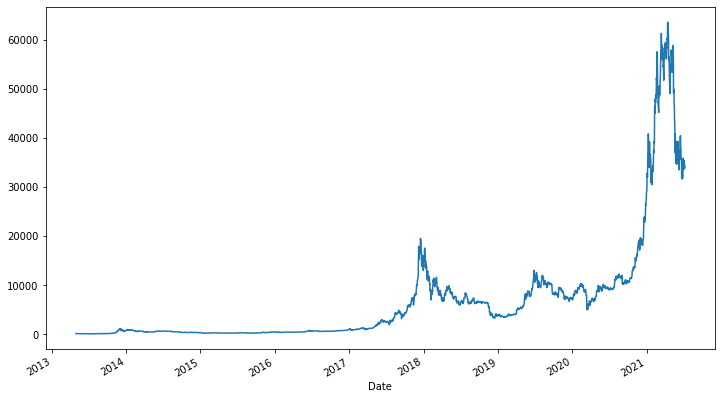

In [9]:
df_btc['Close'].plot(figsize=(12, 7));

There is clearly a trend in cryptocurrencies as both BTC and ETH show that there's a upward trend over time. Hence, there is no seasonality, as the closing price does not take on fixed and known frequency.

<AxesSubplot:xlabel='Date'>

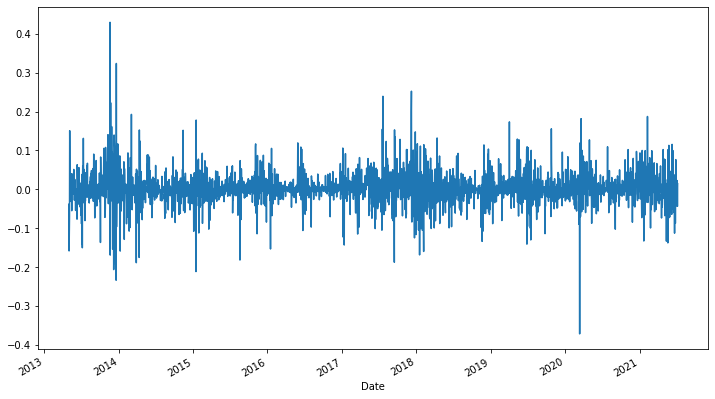

In [10]:
df_btc['Close'].pct_change().plot(figsize=(12, 7))

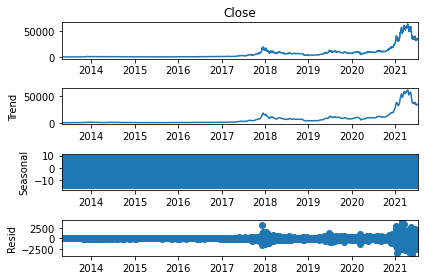

In [11]:
decomp_btc = seasonal_decompose(df_btc['Close'])
decomp_btc.plot();

According to the seasonality plot above, it does not appear to have a season for BTC prices

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

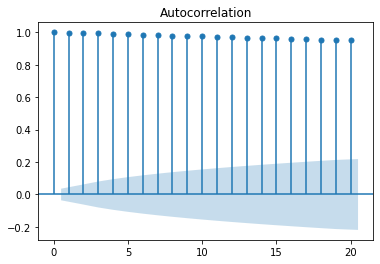

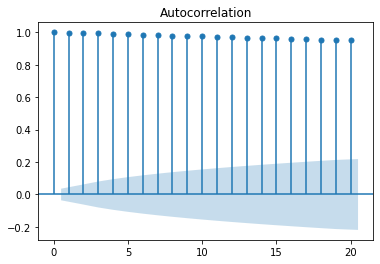

In [13]:
plot_acf(df_btc['Close'], lags=20)

There is evidence that a trend in the price of BTC exists as the autocorrelation plot has large and positive value for small lags (lags 1, 2, 3.. etc). The plot shows that there is no seasonality in the price of BTC. 

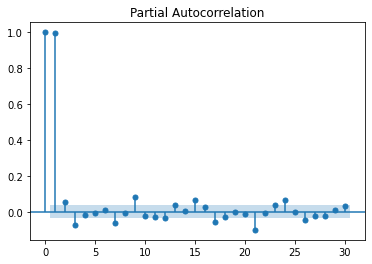

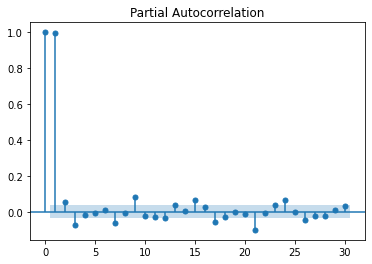

In [14]:
plot_pacf(df_btc['Close'], lags=30)

The value of partial correlation only has 6 dots that go outside of the blue band, which represents 95% confidence interval. This means that the correlation between prices today and yesterday are NOT statistically significant. (No surprise here).

However, it does seems like there's a small trend here where the positive significant values peak a bit for every 7-8 days or so. There are more negative significant values outside of the blue band than the positive ones.

#### ETH

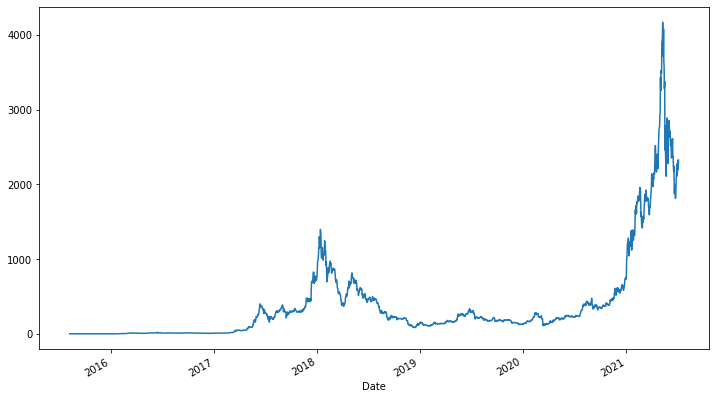

In [15]:
df_eth['Close'].plot(figsize=(12, 7));

<AxesSubplot:xlabel='Date'>

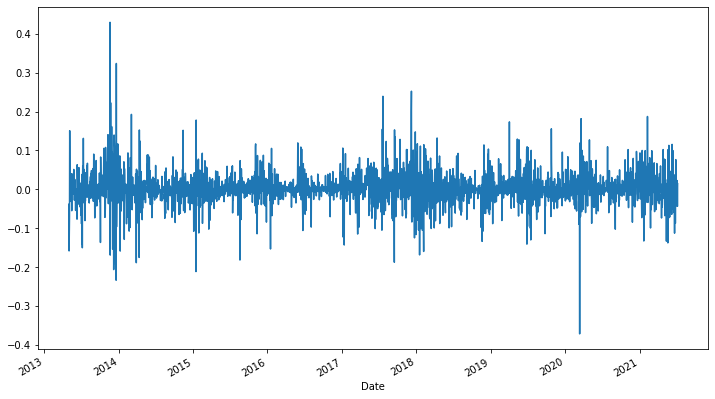

In [16]:
df_btc['Close'].pct_change().plot(figsize=(12, 7))

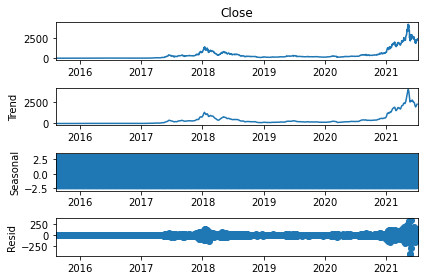

In [17]:
decomp_eth = seasonal_decompose(df_eth['Close'])
decomp_eth.plot();

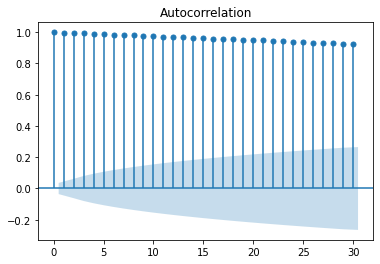

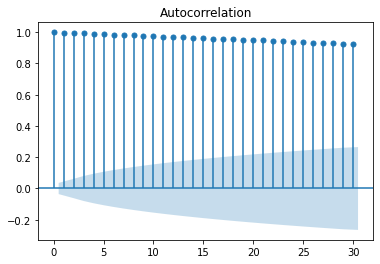

In [18]:
plot_acf(df_btc['Close'], lags=30)

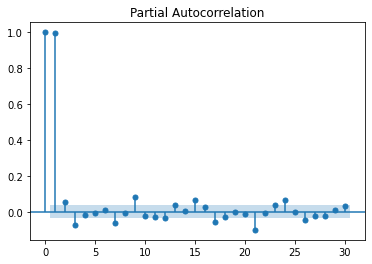

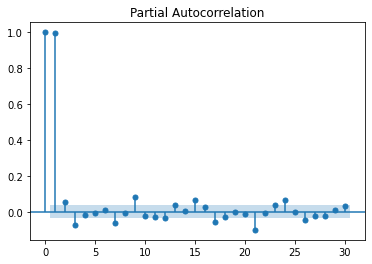

In [19]:
plot_pacf(df_btc['Close'], lags=30)

#### ADA

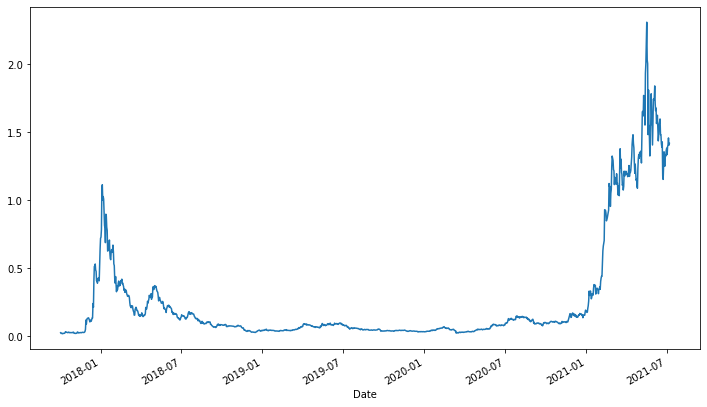

In [20]:
df_ada['Close'].plot(figsize=(12, 7));

<AxesSubplot:xlabel='Date'>

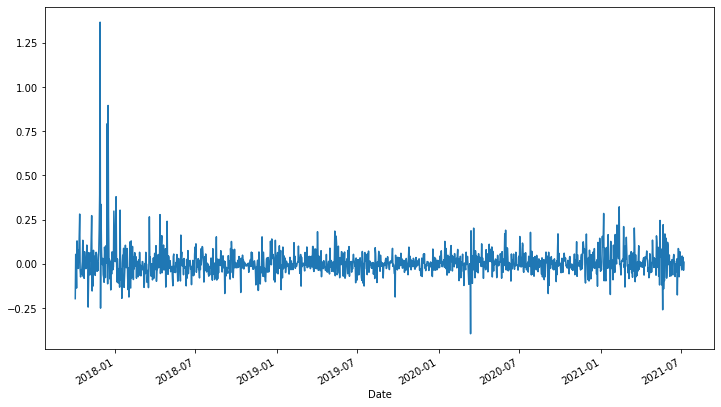

In [21]:
df_ada['Close'].pct_change().plot(figsize=(12, 7))

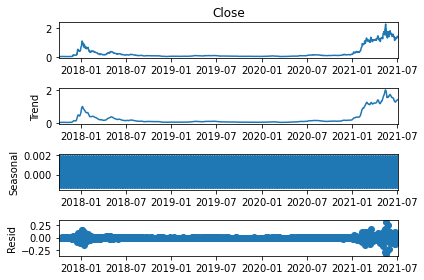

In [22]:
decomp_ada = seasonal_decompose(df_ada['Close'])
decomp_ada.plot();

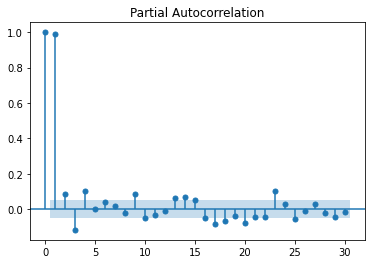

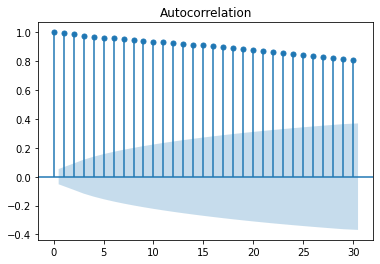

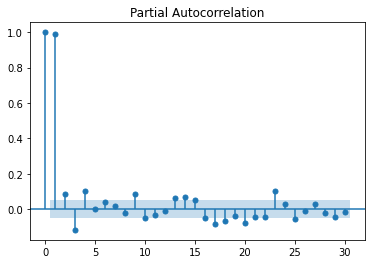

In [23]:
plot_acf(df_ada['Close'], lags=30)
plot_pacf(df_ada['Close'], lags=30)

#### DOG

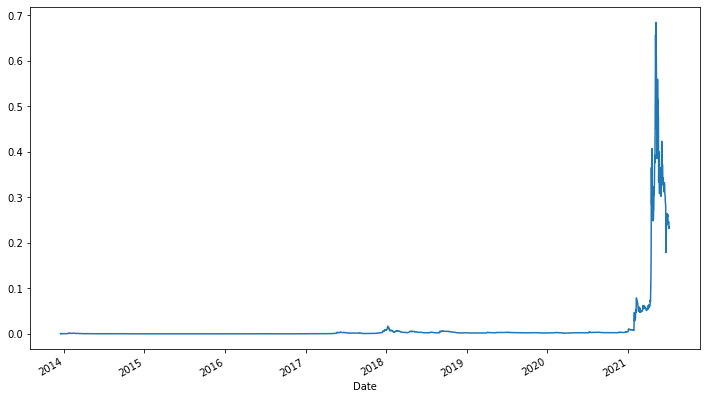

In [24]:
df_dog['Close'].plot(figsize=(12, 7));

<AxesSubplot:xlabel='Date'>

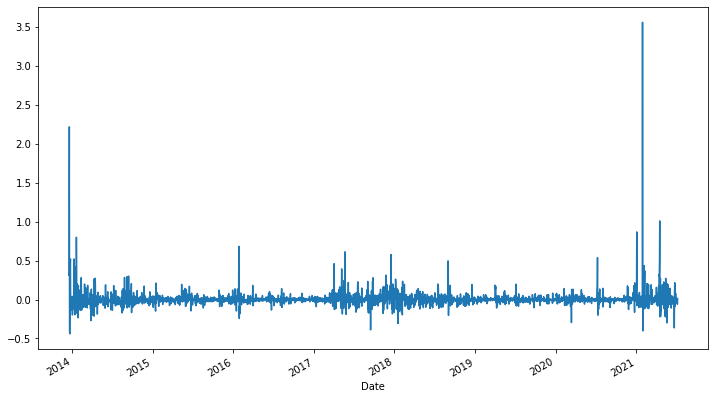

In [25]:
df_dog['Close'].pct_change().plot(figsize=(12, 7))

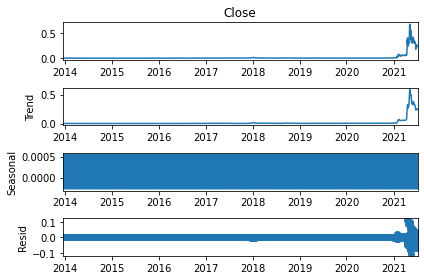

In [26]:
decomp_dog = seasonal_decompose(df_dog['Close'])
decomp_dog.plot();

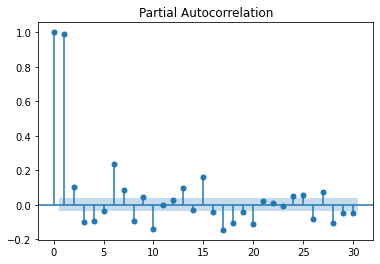

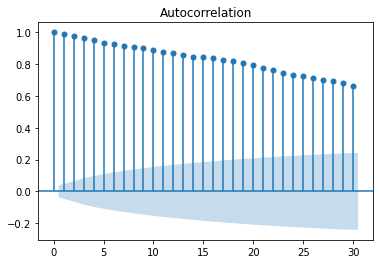

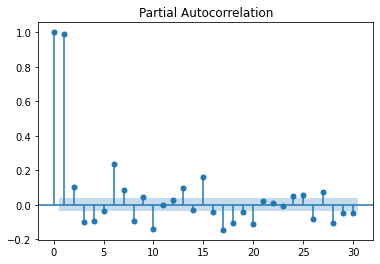

In [27]:
plot_acf(df_dog['Close'], lags=30)
plot_pacf(df_dog['Close'], lags=30)

### Create a dataframe for model fitting purpose

In [28]:
df_btc['lag1'] = df_btc['Close'].shift(1)
df_btc['lag2'] = df_btc['Close'].shift(2)
df_btc['lag7'] = df_btc['Close'].shift(7)
df_btc['time'] = range(0, df_btc.shape[0])

In [29]:
df_btc.head()

,High,Low,Open,Close,Marketcap,lag1,lag2,lag7,time
Date,,,,,,,,,
2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,1.603769e+09,NaN,NaN,NaN,0
2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,1.542813e+09,144.539993,NaN,NaN,1
2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,1.298955e+09,139.000000,144.539993,NaN,2
2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,1.168517e+09,116.989998,139.000000,NaN,3
2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,1.085995e+09,105.209999,116.989998,NaN,4


In [30]:
df_btc.tail()

,High,Low,Open,Close,Marketcap,lag1,lag2,lag7,time
Date,,,,,,,,,
2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,6.354508e+11,33572.117653,35040.837249,31637.780055,2986
2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,6.499397e+11,33897.048590,33572.117653,32186.277671,2987
2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,6.615748e+11,34668.548402,33897.048590,34649.644588,2988
2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,6.326962e+11,35287.779766,34668.548402,34434.335314,2989
2021-07-06 23:59:59,35038.536363,33599.916169,33723.509655,34235.193451,6.418992e+11,33746.002456,35287.779766,35867.777735,2990


In [31]:
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2991 entries, 2013-04-29 23:59:59 to 2021-07-06 23:59:59
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2991 non-null   float64
 1   Low        2991 non-null   float64
 2   Open       2991 non-null   float64
 3   Close      2991 non-null   float64
 4   Marketcap  2991 non-null   float64
 5   lag1       2990 non-null   float64
 6   lag2       2989 non-null   float64
 7   lag7       2984 non-null   float64
 8   time       2991 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 233.7 KB


### Train-Test Split to prepare X and Y

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df_btc.drop(columns=['High', 'Low', 'Open', 'Close', 'Marketcap']),
                                                   df_btc['Close'],
                                                   test_size=0.2,
                                                   shuffle=False)

In [33]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2392, 4)
(599, 4)
(2392,)
(599,)


In [34]:
X_train

,lag1,lag2,lag7,time
Date,,,,
2013-04-29 23:59:59,NaN,NaN,NaN,0
2013-04-30 23:59:59,144.539993,NaN,NaN,1
2013-05-01 23:59:59,139.000000,144.539993,NaN,2
2013-05-02 23:59:59,116.989998,139.000000,NaN,3
2013-05-03 23:59:59,105.209999,116.989998,NaN,4
...,...,...,...,...
2019-11-11 23:59:59,9055.526057,8813.582487,9412.611871,2387
2019-11-12 23:59:59,8757.788542,9055.526057,9342.527179,2388
2019-11-13 23:59:59,8815.662539,8757.788542,9360.879912,2389


### Fit model and create predictions

In [35]:
import statsmodels.api as sm

In [36]:
# Fit a statsmodel (linear model)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

X_train

,const,lag1,lag2,lag7,time
Date,,,,,
2013-04-29 23:59:59,1.0,NaN,NaN,NaN,0
2013-04-30 23:59:59,1.0,144.539993,NaN,NaN,1
2013-05-01 23:59:59,1.0,139.000000,144.539993,NaN,2
2013-05-02 23:59:59,1.0,116.989998,139.000000,NaN,3
2013-05-03 23:59:59,1.0,105.209999,116.989998,NaN,4
...,...,...,...,...,...
2019-11-11 23:59:59,1.0,9055.526057,8813.582487,9412.611871,2387
2019-11-12 23:59:59,1.0,8757.788542,9055.526057,9342.527179,2388
2019-11-13 23:59:59,1.0,8815.662539,8757.788542,9360.879912,2389


In [37]:
X_test

,const,lag1,lag2,lag7,time
Date,,,,,
2019-11-16 23:59:59,1.0,8491.992012,8708.095095,8813.582487,2392
2019-11-17 23:59:59,1.0,8550.760557,8491.992012,9055.526057,2393
2019-11-18 23:59:59,1.0,8577.975782,8550.760557,8757.788542,2394
2019-11-19 23:59:59,1.0,8309.285983,8577.975782,8815.662539,2395
2019-11-20 23:59:59,1.0,8206.145918,8309.285983,8808.262582,2396
...,...,...,...,...,...
2021-07-02 23:59:59,1.0,33572.117653,35040.837249,31637.780055,2986
2021-07-03 23:59:59,1.0,33897.048590,33572.117653,32186.277671,2987
2021-07-04 23:59:59,1.0,34668.548402,33897.048590,34649.644588,2988


In [38]:
y_train

Date
2013-04-29 23:59:59     144.539993
2013-04-30 23:59:59     139.000000
2013-05-01 23:59:59     116.989998
2013-05-02 23:59:59     105.209999
2013-05-03 23:59:59      97.750000
                          ...     
2019-11-11 23:59:59    8757.788542
2019-11-12 23:59:59    8815.662539
2019-11-13 23:59:59    8808.262582
2019-11-14 23:59:59    8708.095095
2019-11-15 23:59:59    8491.992012
Name: Close, Length: 2392, dtype: float64

In [39]:
### Drop nulls
X_train.dropna(inplace=True)
y_train = y_train[X_train.index]

In [40]:
# instantiate the linear regression model
lm = sm.OLS(y_train, X_train)

# fit model
lm_results = lm.fit()

# display summary
print(lm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.350e+05
Date:                Wed, 25 Aug 2021   Prob (F-statistic):               0.00
Time:                        16:56:41   Log-Likelihood:                -16546.
No. Observations:                2385   AIC:                         3.310e+04
Df Residuals:                    2380   BIC:                         3.313e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.3447     11.054     -0.936      0.3

In [41]:
# Generate predicted tests values
lm_results.predict(X_test)

Date
2019-11-16 23:59:59     8486.580845
2019-11-17 23:59:59     8559.777982
2019-11-18 23:59:59     8583.537653
2019-11-19 23:59:59     8303.304101
2019-11-20 23:59:59     8209.528879
                           ...     
2021-07-02 23:59:59    33372.079070
2021-07-03 23:59:59    33786.080829
2021-07-04 23:59:59    34584.921915
2021-07-05 23:59:59    35188.732680
2021-07-06 23:59:59    33563.430669
Length: 599, dtype: float64

In [42]:
y_test

Date
2019-11-16 23:59:59     8550.760557
2019-11-17 23:59:59     8577.975782
2019-11-18 23:59:59     8309.285983
2019-11-19 23:59:59     8206.145918
2019-11-20 23:59:59     8027.268243
                           ...     
2021-07-02 23:59:59    33897.048590
2021-07-03 23:59:59    34668.548402
2021-07-04 23:59:59    35287.779766
2021-07-05 23:59:59    33746.002456
2021-07-06 23:59:59    34235.193451
Name: Close, Length: 599, dtype: float64

In [43]:
from sklearn.metrics import r2_score, mean_squared_error

In [44]:
# Check R2 and MSE scores
r2_score(y_test, lm_results.predict(X_test))

0.9950524449969521

In [45]:
# calculate MSE
mean_squared_error(y_test, lm_results.predict(X_test))**0.5

1226.8840725752993

### Plot Predictions

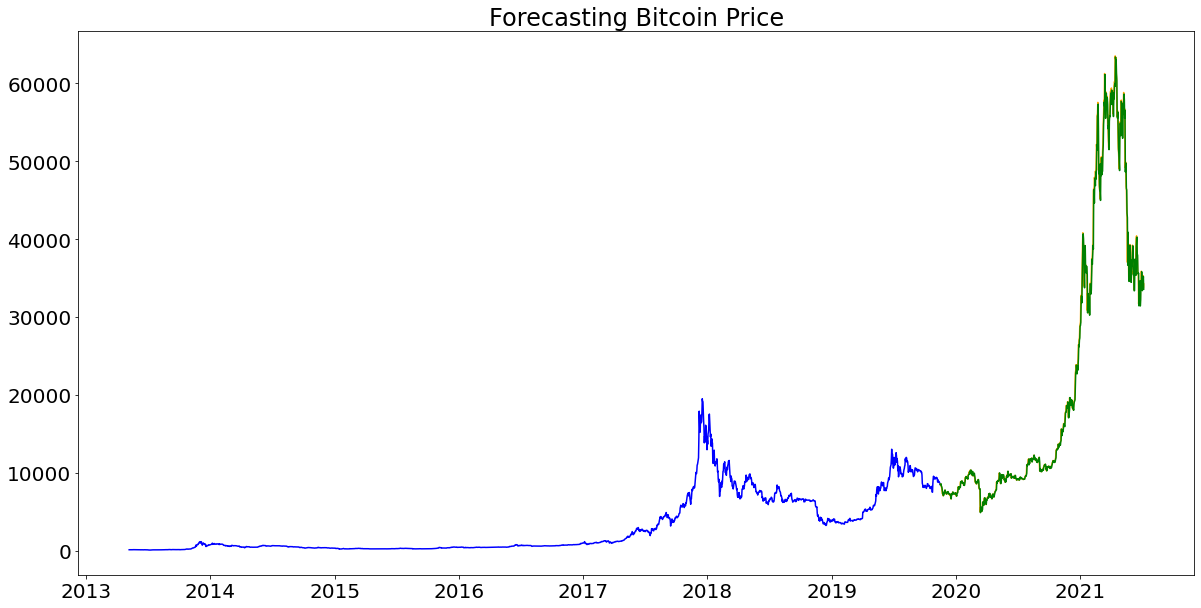

In [46]:
# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(y_train.index, y_train.values, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test.values, color = 'orange')

# Plot predicted test values.
plt.plot(lm_results.predict(X_test), color = 'green')

# Set label.
plt.title(label = 'Forecasting Bitcoin Price', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

### ARIMA Model

First we have to check for stationary, and <b>find parameter d.</b>

In [47]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

In [48]:
df_btc['first_diff_close'] = df_btc['Close'].diff(1)
df_btc['second_diff_close'] = df_btc['Close'].diff(2)

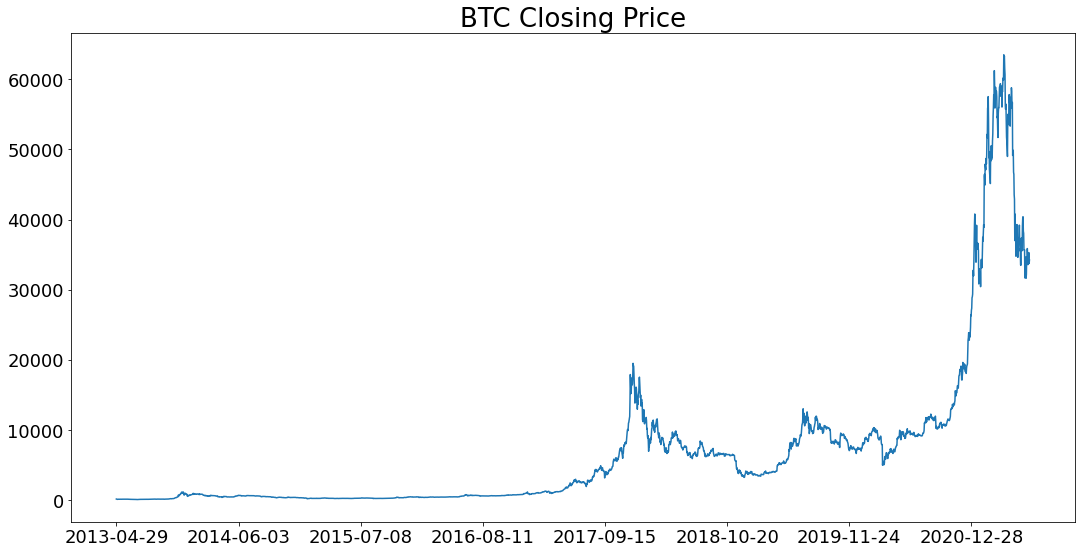

In [49]:
plot_series(df_btc, ['Close'], title = 'BTC Closing Price', steps = 400)

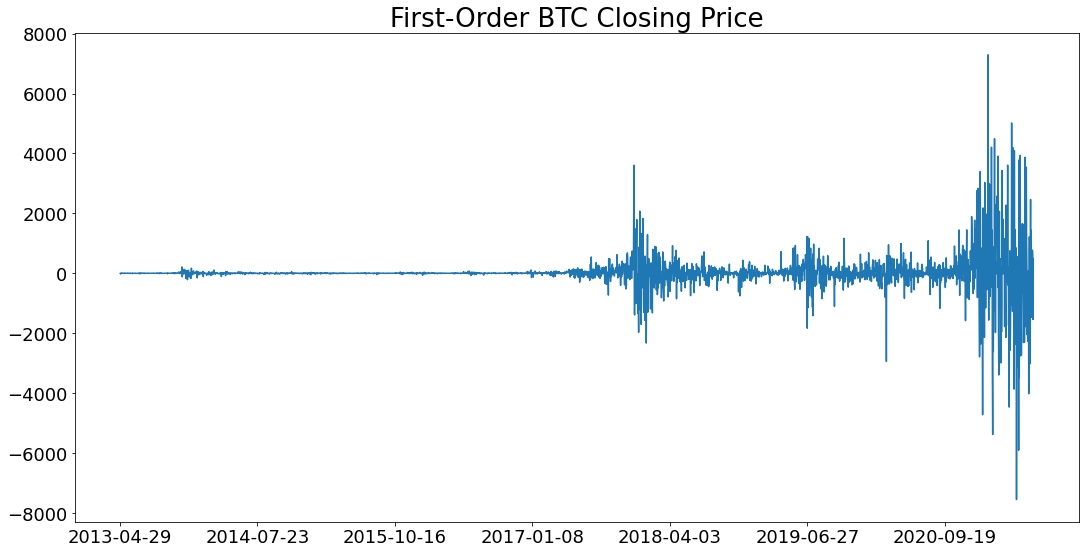

In [50]:
plot_series(df_btc, ['first_diff_close'], title = 'First-Order BTC Closing Price', steps = 450)

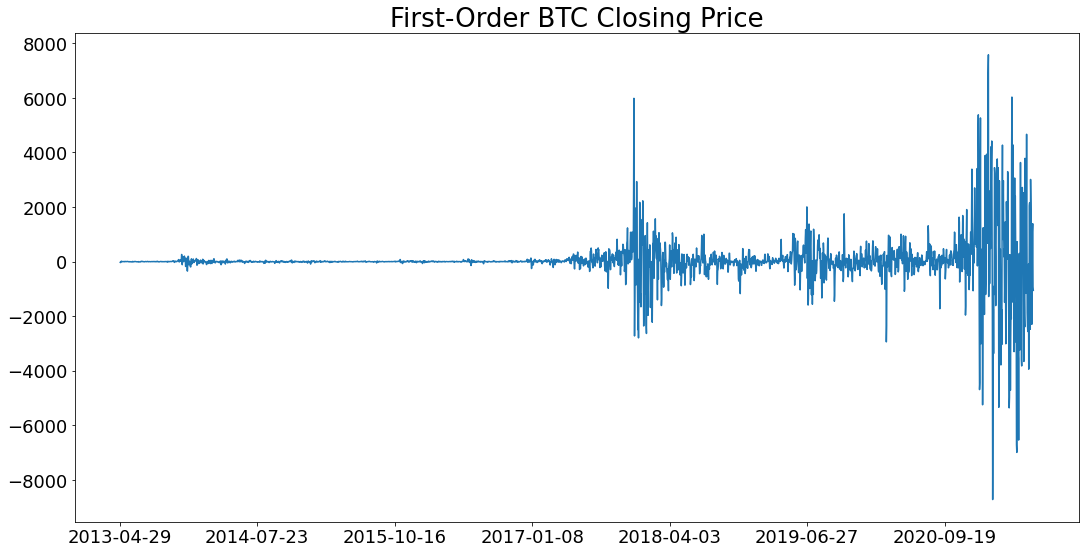

In [51]:
plot_series(df_btc, ['second_diff_close'], title = 'First-Order BTC Closing Price', steps = 450)

#### Parameter d - Augmented Dickey-Fuller

Using Augmented Dickey-Fuller to find p-value for first-older and second-older, in order to find Parameter d

In [52]:
# Import Augmented Dickey-Fuller test.
from statsmodels.tsa.stattools import adfuller

# Run ADF test on original (non-differenced!) data.
adfuller(df_btc['Close'])

(-0.7973098451195635,
 0.8199110033239143,
 29,
 2961,
 {'1%': -3.4325603944919445,
  '5%': -2.8625166073924957,
  '10%': -2.567289874591689},
 45929.032374699236)

In [53]:
# Code written by Joseph Nelson (to extract only the things that we need from above output)

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [54]:
interpret_dftest(adfuller(df_btc['Close']))

Test Statistic   -0.797310
p-value           0.819911
dtype: float64

p-value = 082, not significant, fail to reject null hypthosis... our data is NOT STATIONARY.

In [55]:
interpret_dftest(adfuller(df_btc['first_diff_close'].dropna()))

Test Statistic   -8.912361e+00
p-value           1.095586e-14
dtype: float64

In [56]:
interpret_dftest(adfuller(df_btc['second_diff_close'].dropna()))

Test Statistic   -8.115402e+00
p-value           1.194742e-12
dtype: float64

Our data for first-order, and second-order are both stationary as their p-value is well below 0.05. Hence, we would reject H0 and accept that our first-order differenced data are stationary. <b>We choose ARIMA model parameter d = 1.</b>

#### Parameter p

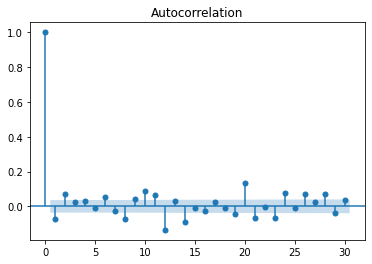

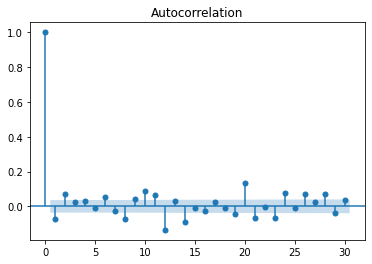

In [57]:
plot_acf(df_btc['first_diff_close'].dropna(), lags=30)

As the autocorrelation graph shown above, there is statistically significant correlation between Yt and Yt-k for $k = 1, 2, 6, 8, 9, 10, 11, 12, 14, 19, 20, 12, 23, 24, 26, and 28 for first-older

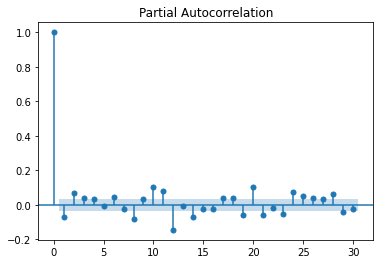

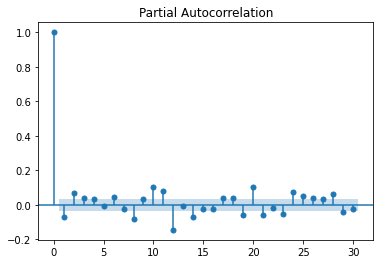

In [58]:
plot_pacf(df_btc['first_diff_close'].dropna(), lags=30)

According to the partial autocorrelation plot above, there is a significant correlation between Yt and Yt-k for lag k, accounting for all lower-order lags.

Because the PACF graph above shows that there is a sharp cut-ff, and the lag-1 PACF is negative, we <b> choose ARIMA model parameter p = 0. </b>

#### Parameter q - Moving Average Order

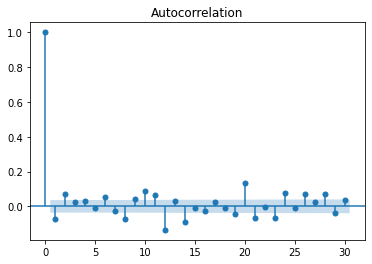

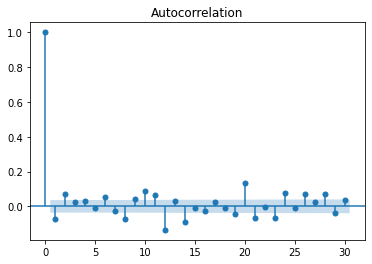

In [59]:
plot_acf(df_btc['first_diff_close'].dropna(), lags=30)

Based on the ACF graph above, we should <b> set ARIMA parameter q = 0 </b>, because the first non-significant value is 1.

#### Build the ARIMA model

In [60]:
from statsmodels.tsa.arima_model import ARIMA

In [61]:
from datetime import datetime, timedelta

In [62]:
y_test

Date
2019-11-16 23:59:59     8550.760557
2019-11-17 23:59:59     8577.975782
2019-11-18 23:59:59     8309.285983
2019-11-19 23:59:59     8206.145918
2019-11-20 23:59:59     8027.268243
                           ...     
2021-07-02 23:59:59    33897.048590
2021-07-03 23:59:59    34668.548402
2021-07-04 23:59:59    35287.779766
2021-07-05 23:59:59    33746.002456
2021-07-06 23:59:59    34235.193451
Name: Close, Length: 599, dtype: float64

In [63]:
# Instantiate model 
# ARIMA parameter p = 0, d = 1, q = 0

model = ARIMA(endog=y_train.astype(float).dropna(),
             order=(0, 1, 0)) #(p, d, q)

# Fit model
arima_0_1_0 = model.fit()

# Generate predictions
preds = model.predict(params=arima_0_1_0.params,
                     start=datetime.strptime('2019-11-16T23:59:59', '%Y-%m-%dT%H:%M:%S'),
                     end=datetime.strptime('2021-07-06T23:59:59', '%Y-%m-%dT%H:%M:%S'))

/Users/emmsytsui/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/emmsytsui/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provi

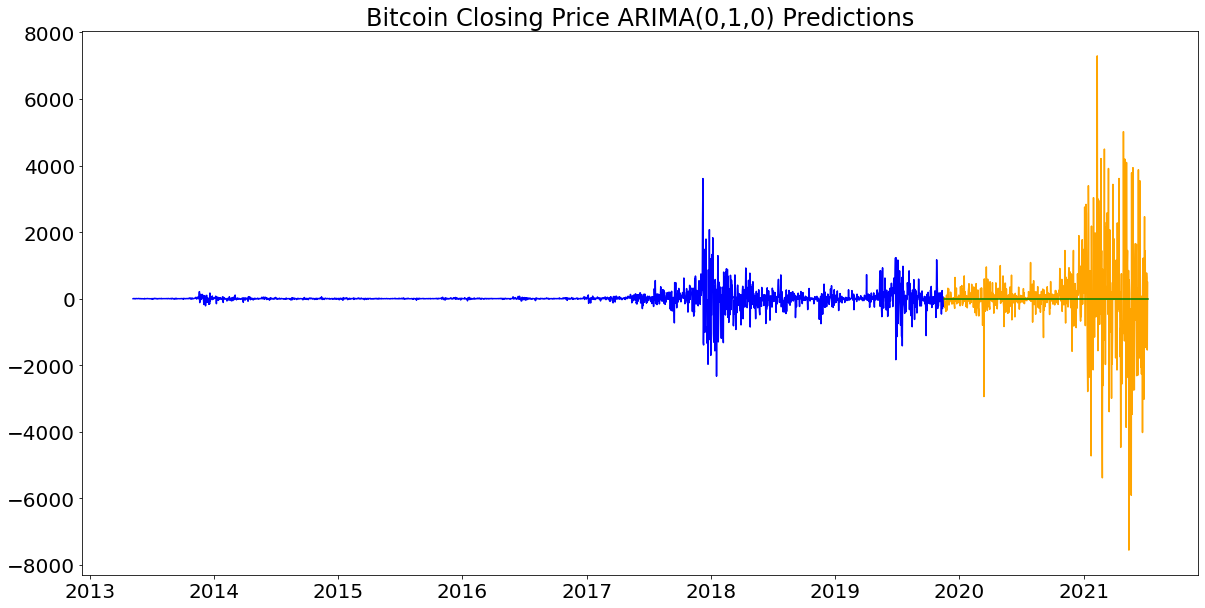

In [64]:
# Plot the data and predictions

plt.figure(figsize=(20, 10))

# plot training data
plt.plot(y_train.index, pd.DataFrame(y_train).diff(), color = 'blue')

# plot testing data
plt.plot(y_test.index, pd.DataFrame(y_test).diff(), color = 'orange')

# plot predicted test values
plt.plot(y_test.index, preds, color = 'green')

# set label
plt.title(label = 'Bitcoin Closing Price ARIMA(0,1,0) Predictions', fontsize=24)

# resize tick marks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

In [65]:
r2_score(pd.DataFrame(y_test).diff().dropna(), preds[1:])

-0.001051416985359488

### Seasonal Model with SARIMAX

In [66]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

/Users/emmsytsui/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/emmsytsui/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


427576441.9974448
-0.40539156667694387


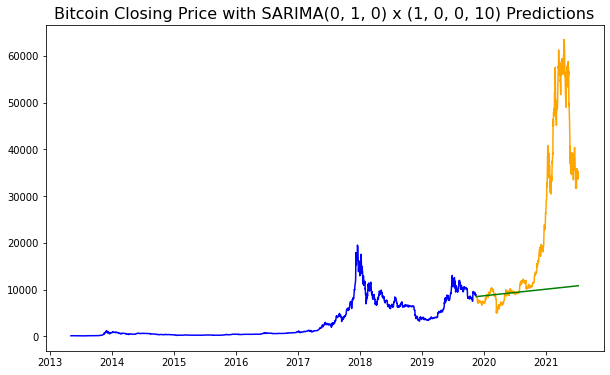

In [67]:
# Fit SARIMA(0,2,1) x (1, 0, 0, 10)

sarima = SARIMAX(endog = y_train.astype(float).dropna(),
                 order = (0, 2, 1),              # (p, d, q)
                 seasonal_order = (0, 0, 0, 0)) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start=datetime.strptime('2019-11-16T23:59:59', '%Y-%m-%dT%H:%M:%S'),
                      end=datetime.strptime('2021-07-06T23:59:59', '%Y-%m-%dT%H:%M:%S'))

# Evaluate predictions.
print(mean_squared_error(y_test, preds))
print(r2_score(y_test, preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Bitcoin Closing Price with SARIMA(0, 1, 0) x (1, 0, 0, 10) Predictions', fontsize=16)
plt.show();

### Manual GridSearch

In [68]:
# Starting MSE and (P, D, Q, S).
best_mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0
final_S = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            for S in range(0,13,4):
                try:
                    print(f'Attempting to fit SARIMAX(0,2,1)x({P},{D},{Q},{S})')
                    # Instantiate SARIMAX model.
                    sarimax = SARIMAX(endog = y_train[1:],
                                     order = (0, 2, 1),              # (p, d, q)
                                     seasonal_order = (P, D, Q, S),  # (P, D, Q, S)
                                     exog = X_train['first_diff_close'].dropna()) 
 
                    # Fit SARIMAX model.
                    model = sarimax.fit()

                    # Generate predictions based on test set.
                    preds = model.predict(start=datetime.strptime('2019-11-16T23:59:59', '%Y-%m-%dT%H:%M:%S'),
                                          end=datetime.strptime('2021-07-06T23:59:59', '%Y-%m-%dT%H:%M:%S'),
                                          exog=X_test[['first_diff_close']].dropna())

                    # Evaluate predictions.
                    print(f'The MSE for (0, 2, 1)x({P},{D},{Q},{S}) is: {mean_squared_error(y_test[1:len(y_test)-1], preds)}')

                    # Save for final report.
                    if best_mse > mean_squared_error(y_test[1:len(y_test)-1], preds):
                        best_mse = mean_squared_error(y_test[1:len(y_test)-1], preds)
                        final_P = P
                        final_D = D
                        final_Q = Q
                        final_S = S

                except:
                    pass

print(f'Our model that minimizes MSE on the testing data is the SARIMAX(0, 2, 1)x({final_P},{final_D},{final_Q},{final_S}).')
print(f'This model has an MSE of {best_mse}.')

Attempting to fit SARIMAX(0,2,1)x(0,0,0,0)
Attempting to fit SARIMAX(0,2,1)x(0,0,0,4)
Attempting to fit SARIMAX(0,2,1)x(0,0,0,8)
Attempting to fit SARIMAX(0,2,1)x(0,0,0,12)
Attempting to fit SARIMAX(0,2,1)x(0,1,0,0)
Attempting to fit SARIMAX(0,2,1)x(0,1,0,4)
Attempting to fit SARIMAX(0,2,1)x(0,1,0,8)
Attempting to fit SARIMAX(0,2,1)x(0,1,0,12)
Attempting to fit SARIMAX(0,2,1)x(0,2,0,0)
Attempting to fit SARIMAX(0,2,1)x(0,2,0,4)
Attempting to fit SARIMAX(0,2,1)x(0,2,0,8)
Attempting to fit SARIMAX(0,2,1)x(0,2,0,12)
Attempting to fit SARIMAX(0,2,1)x(0,0,1,0)
Attempting to fit SARIMAX(0,2,1)x(0,0,1,4)
Attempting to fit SARIMAX(0,2,1)x(0,0,1,8)
Attempting to fit SARIMAX(0,2,1)x(0,0,1,12)
Attempting to fit SARIMAX(0,2,1)x(0,1,1,0)
Attempting to fit SARIMAX(0,2,1)x(0,1,1,4)
Attempting to fit SARIMAX(0,2,1)x(0,1,1,8)
Attempting to fit SARIMAX(0,2,1)x(0,1,1,12)
Attempting to fit SARIMAX(0,2,1)x(0,2,1,0)
Attempting to fit SARIMAX(0,2,1)x(0,2,1,4)
Attempting to fit SARIMAX(0,2,1)x(0,2,1,8)
Attemp

### Summary

After testing and training 3 different models - Linear Model, ARIMA, & SARIMA. It is apparent that ARIMA & SARIMA are both bad models to predict Bitcoin Cryptocurrency. 

<b>Linear Model, on the other hand, using statsmodels original least square (sm.OLS) performs exceptionally well with R2 score at 0.996 for training score, and 0.995 for testing score. </b>

There are many reasons for such bad performance on ARIMA & SARIMA that affect the closing price for BTC:
- The testing data looks very different than the training data, but this isn't something we have much control over.
- COVID-19 pandemic that negatively affected BTC price during the start of the pandemic in March 2020
- Sudden increase usage of cryptocurrency, including purchasing and selling, on large trading platforms applications as the technology improves
- Increase media coverage of cryptocurrency, and increase of the mining companies

Hence, forcasting time series is extremely difficult to do well, and forcasting cryptocurrencies are not any different as we can see here, even though we choose the most stable and safest cryptocurrency (BTC) to predict.

### Save model

Saving time series linear model of price prediction on Bitcoin.

In [69]:
filename = 'assets/linear_model.pkl'
pickle.dump(lm, open(filename, 'wb'))

In [70]:
# model later from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, y_test)
#print(result)